In [90]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
pd.options.display.float_format = '{:.2f}'.format
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams["axes.formatter.limits"] = (-5, 12)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from scipy import stats
import shap
import warnings
from matplotlib import style
style.use('dark_background')
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [91]:
Dados_LDL = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_LDL.xlsx')
Dados_Boleto_17h = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_Boleto_17h.xlsx')
Contas_ativas = pd.read_excel('/home/stnog/Modelo_Boleto/Contas_Ativas.xlsx')
Dados_celcoin = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_celcoin.xlsx')
boleto_in = pd.read_excel('/home/stnog/Modelo_Boleto/boleto_in.xlsx')
Dados_LDL

,inserted_at,valor_brl,code
0,2022-08-12 10:01:17.271,27946546.34,LDL0021
1,2022-08-11 10:00:59.414,38249311.84,LDL0021
2,2022-08-10 10:00:59.290,3289424.40,LDL0021
3,2022-08-09 10:00:45.688,11225517.79,LDL0021
4,2022-08-08 10:01:22.434,16430459.44,LDL0021
...,...,...,...
405,2021-01-08 10:00:53.339,10678826.92,LDL0021
406,2021-01-07 10:01:03.091,11441470.87,LDL0021
407,2021-01-06 10:00:31.806,15693545.34,LDL0021
408,2021-01-05 10:00:46.254,47522788.37,LDL0021


In [92]:
feriados = pd.read_csv('/home/stnog/Modelo_Boleto/Feriados.csv')
feriado=pd.to_datetime(feriados['Data'])
feriados=pd.to_datetime(feriados['Data']).astype('str').tolist()
dia_de_semana = pd.bdate_range('2021-01-01', '2037-12-31')
dia_de_semana = dia_de_semana.astype('str').tolist()
wDays = [x for x in dia_de_semana if x not in feriados ]

In [93]:
Dados_celcoin = Dados_celcoin.rename(columns={'dia': 'Dia'})
Dados_celcoin = Dados_celcoin.rename(columns={'qtd': 'qtd_celcoin'})
Dados_celcoin['Dia'] = pd.to_datetime(Dados_celcoin['Dia'])
Dados_celcoin

,valor_celcoin,qtd_celcoin,Dia
0,25.00,1,2020-12-31
1,1330.00,3,2021-01-04
2,11395769.59,20905,2021-07-06
3,17920612.99,27184,2021-09-10
4,56934.12,154,2021-10-02
...,...,...,...
119,9597881.34,14043,2022-08-11
120,85447191.09,94550,2022-08-15
121,29001732.26,38264,2022-08-16
122,24386931.15,32362,2022-08-17


In [94]:
Dados_celcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   valor_celcoin  124 non-null    float64       
 1   qtd_celcoin    124 non-null    int64         
 2   Dia            124 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.0 KB


In [95]:
boleto_in = boleto_in.rename(columns={'dia': 'Dia'})
boleto_in['Dia'] = pd.to_datetime(boleto_in['Dia'])
boleto_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   boleto_out  410 non-null    float64       
 1   boleto_in   410 non-null    float64       
 2   Dia         410 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.7 KB


In [96]:
boleto_in = boleto_in.drop('boleto_out', axis=1)

In [97]:
boleto_in

,boleto_in,Dia
0,1063378.41,2020-12-31
1,1673110.39,2021-01-05
2,1296749.14,2021-01-06
3,941216.34,2021-01-07
4,1145191.42,2021-01-08
...,...,...
405,4904353.38,2022-08-15
406,8612282.18,2022-08-16
407,5174764.01,2022-08-17
408,4430708.44,2022-08-18


In [98]:
Contas_ativas = Contas_ativas.rename(columns={'dia': 'Dia'})
Contas_ativas['Dia'] = pd.to_datetime(Contas_ativas['Dia'])
Contas_ativas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Dia            592 non-null    datetime64[ns]
 1   contas_ativas  592 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.4 KB


In [99]:
Contas_ativas['weekday'] = pd.to_datetime(Contas_ativas['Dia']).dt.weekday
Contas_ativas

,Dia,contas_ativas,weekday
0,2021-01-01,9861,4
1,2021-01-02,16748,5
2,2021-01-03,12766,6
3,2021-01-04,93248,0
4,2021-01-05,82573,1
...,...,...,...
587,2022-08-11,329027,3
588,2022-08-12,337290,4
589,2022-08-13,210638,5
590,2022-08-14,140831,6


In [100]:
Contas_ativas = Contas_ativas[(Contas_ativas['weekday']!=6)&(Contas_ativas['weekday']!=5)].reset_index(drop=True)
Contas_ativas

,Dia,contas_ativas,weekday
0,2021-01-01,9861,4
1,2021-01-04,93248,0
2,2021-01-05,82573,1
3,2021-01-06,174554,2
4,2021-01-07,89040,3
...,...,...,...
417,2022-08-09,319703,1
418,2022-08-10,331486,2
419,2022-08-11,329027,3
420,2022-08-12,337290,4


In [101]:
Contas_ativas['Contas_D-1'] = Contas_ativas['contas_ativas'].shift(1)
Contas_ativas

,Dia,contas_ativas,weekday,Contas_D-1
0,2021-01-01,9861,4,nan
1,2021-01-04,93248,0,9861.00
2,2021-01-05,82573,1,93248.00
3,2021-01-06,174554,2,82573.00
4,2021-01-07,89040,3,174554.00
...,...,...,...,...
417,2022-08-09,319703,1,360089.00
418,2022-08-10,331486,2,319703.00
419,2022-08-11,329027,3,331486.00
420,2022-08-12,337290,4,329027.00


In [102]:
Contas_ativas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Dia            422 non-null    datetime64[ns]
 1   contas_ativas  422 non-null    int64         
 2   weekday        422 non-null    int64         
 3   Contas_D-1     421 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 KB


In [103]:
Contas_ativas['feriado'] = np.where(Contas_ativas.Dia.isin(pd.to_datetime(feriados)), 1, 0)
Contas_ativas

,Dia,contas_ativas,weekday,Contas_D-1,feriado
0,2021-01-01,9861,4,nan,1
1,2021-01-04,93248,0,9861.00,0
2,2021-01-05,82573,1,93248.00,0
3,2021-01-06,174554,2,82573.00,0
4,2021-01-07,89040,3,174554.00,0
...,...,...,...,...,...
417,2022-08-09,319703,1,360089.00,0
418,2022-08-10,331486,2,319703.00,0
419,2022-08-11,329027,3,331486.00,0
420,2022-08-12,337290,4,329027.00,0


In [104]:
Dados_Boleto_17h = Dados_Boleto_17h.rename(columns={'paid_at': 'Dia'})
Dados_Boleto_17h

,Dia,sum,count
0,2021-01-01,777769.44,1134
1,2021-01-02,1688196.95,3303
2,2021-01-03,1149937.54,1904
3,2021-01-04,30095294.37,35960
4,2021-01-05,12722553.82,18050
...,...,...,...
587,2022-08-12,28267553.43,37632
588,2022-08-13,7228940.96,11852
589,2022-08-14,2095309.70,3104
590,2022-08-15,1473718.02,1488


In [105]:
Dados_Boleto_17h = pd.merge(Dados_Boleto_17h, Dados_celcoin, on='Dia', how='left')

In [106]:
Dados_Boleto_17h = Dados_Boleto_17h.fillna(0)

In [107]:
Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin
0,2021-01-01,777769.44,1134,0.00,0.00
1,2021-01-02,1688196.95,3303,0.00,0.00
2,2021-01-03,1149937.54,1904,0.00,0.00
3,2021-01-04,30095294.37,35960,1330.00,3.00
4,2021-01-05,12722553.82,18050,0.00,0.00
...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00
588,2022-08-13,7228940.96,11852,0.00,0.00
589,2022-08-14,2095309.70,3104,0.00,0.00
590,2022-08-15,1473718.02,1488,85447191.09,94550.00


In [108]:
Dados_Boleto_17h['weekday'] = pd.to_datetime(Dados_Boleto_17h['Dia']).dt.weekday
Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin,weekday
0,2021-01-01,777769.44,1134,0.00,0.00,4
1,2021-01-02,1688196.95,3303,0.00,0.00,5
2,2021-01-03,1149937.54,1904,0.00,0.00,6
3,2021-01-04,30095294.37,35960,1330.00,3.00,0
4,2021-01-05,12722553.82,18050,0.00,0.00,1
...,...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00,4
588,2022-08-13,7228940.96,11852,0.00,0.00,5
589,2022-08-14,2095309.70,3104,0.00,0.00,6
590,2022-08-15,1473718.02,1488,85447191.09,94550.00,0


In [109]:
Dados_Boleto_17h['ajuste_domingo_sum'] = Dados_Boleto_17h['sum'].shift(1)
Dados_Boleto_17h['ajuste_domingo_count'] = Dados_Boleto_17h['count'].shift(1)
Dados_Boleto_17h['ajuste_sab_sum'] = Dados_Boleto_17h['sum'].shift(2)
Dados_Boleto_17h['ajuste_sab_count'] = Dados_Boleto_17h['count'].shift(2)
Dados_Boleto_17h['ajuste_domingo_sum_celcoin'] = Dados_Boleto_17h['valor_celcoin'].shift(1)
Dados_Boleto_17h['ajuste_domingo_count_celcoin'] = Dados_Boleto_17h['qtd_celcoin'].shift(1)
Dados_Boleto_17h['ajuste_sab_sum_celcoin'] = Dados_Boleto_17h['valor_celcoin'].shift(2)
Dados_Boleto_17h['ajuste_sab_count_celcoin'] = Dados_Boleto_17h['qtd_celcoin'].shift(2)
Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin,weekday,ajuste_domingo_sum,ajuste_domingo_count,ajuste_sab_sum,ajuste_sab_count,ajuste_domingo_sum_celcoin,ajuste_domingo_count_celcoin,ajuste_sab_sum_celcoin,ajuste_sab_count_celcoin
0,2021-01-01,777769.44,1134,0.00,0.00,4,nan,nan,nan,nan,nan,nan,nan,nan
1,2021-01-02,1688196.95,3303,0.00,0.00,5,777769.44,1134.00,nan,nan,0.00,0.00,nan,nan
2,2021-01-03,1149937.54,1904,0.00,0.00,6,1688196.95,3303.00,777769.44,1134.00,0.00,0.00,0.00,0.00
3,2021-01-04,30095294.37,35960,1330.00,3.00,0,1149937.54,1904.00,1688196.95,3303.00,0.00,0.00,0.00,0.00
4,2021-01-05,12722553.82,18050,0.00,0.00,1,30095294.37,35960.00,1149937.54,1904.00,1330.00,3.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00,4,19428825.86,26589.00,25596381.09,32553.00,9597881.34,14043.00,15154843.77,21441.00
588,2022-08-13,7228940.96,11852,0.00,0.00,5,28267553.43,37632.00,19428825.86,26589.00,0.00,0.00,9597881.34,14043.00
589,2022-08-14,2095309.70,3104,0.00,0.00,6,7228940.96,11852.00,28267553.43,37632.00,0.00,0.00,0.00,0.00
590,2022-08-15,1473718.02,1488,85447191.09,94550.00,0,2095309.70,3104.00,7228940.96,11852.00,0.00,0.00,0.00,0.00


In [110]:
Dados_Boleto_17h['valor'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['sum']+Dados_Boleto_17h['ajuste_domingo_sum']+Dados_Boleto_17h['ajuste_sab_sum'], Dados_Boleto_17h['sum'])
Dados_Boleto_17h['Qtd'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['count']+Dados_Boleto_17h['ajuste_domingo_count']+Dados_Boleto_17h['ajuste_sab_count'], Dados_Boleto_17h['count'])

Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin,weekday,ajuste_domingo_sum,ajuste_domingo_count,ajuste_sab_sum,ajuste_sab_count,ajuste_domingo_sum_celcoin,ajuste_domingo_count_celcoin,ajuste_sab_sum_celcoin,ajuste_sab_count_celcoin,valor,Qtd
0,2021-01-01,777769.44,1134,0.00,0.00,4,nan,nan,nan,nan,nan,nan,nan,nan,777769.44,1134.00
1,2021-01-02,1688196.95,3303,0.00,0.00,5,777769.44,1134.00,nan,nan,0.00,0.00,nan,nan,1688196.95,3303.00
2,2021-01-03,1149937.54,1904,0.00,0.00,6,1688196.95,3303.00,777769.44,1134.00,0.00,0.00,0.00,0.00,1149937.54,1904.00
3,2021-01-04,30095294.37,35960,1330.00,3.00,0,1149937.54,1904.00,1688196.95,3303.00,0.00,0.00,0.00,0.00,32933428.86,41167.00
4,2021-01-05,12722553.82,18050,0.00,0.00,1,30095294.37,35960.00,1149937.54,1904.00,1330.00,3.00,0.00,0.00,12722553.82,18050.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00,4,19428825.86,26589.00,25596381.09,32553.00,9597881.34,14043.00,15154843.77,21441.00,28267553.43,37632.00
588,2022-08-13,7228940.96,11852,0.00,0.00,5,28267553.43,37632.00,19428825.86,26589.00,0.00,0.00,9597881.34,14043.00,7228940.96,11852.00
589,2022-08-14,2095309.70,3104,0.00,0.00,6,7228940.96,11852.00,28267553.43,37632.00,0.00,0.00,0.00,0.00,2095309.70,3104.00
590,2022-08-15,1473718.02,1488,85447191.09,94550.00,0,2095309.70,3104.00,7228940.96,11852.00,0.00,0.00,0.00,0.00,10797968.68,16444.00


In [111]:
Dados_Boleto_17h['valor_celcoin'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['valor_celcoin']+Dados_Boleto_17h['ajuste_domingo_sum_celcoin']+Dados_Boleto_17h['ajuste_sab_sum_celcoin'], Dados_Boleto_17h['valor_celcoin'])
Dados_Boleto_17h['qtd_celcoin'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['qtd_celcoin']+Dados_Boleto_17h['ajuste_domingo_count_celcoin']+Dados_Boleto_17h['ajuste_sab_count_celcoin'], Dados_Boleto_17h['qtd_celcoin'])

In [112]:
Dados_Boleto_17h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 0 to 591
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dia                           592 non-null    datetime64[ns]
 1   sum                           592 non-null    float64       
 2   count                         592 non-null    int64         
 3   valor_celcoin                 592 non-null    float64       
 4   qtd_celcoin                   592 non-null    float64       
 5   weekday                       592 non-null    int64         
 6   ajuste_domingo_sum            591 non-null    float64       
 7   ajuste_domingo_count          591 non-null    float64       
 8   ajuste_sab_sum                590 non-null    float64       
 9   ajuste_sab_count              590 non-null    float64       
 10  ajuste_domingo_sum_celcoin    591 non-null    float64       
 11  ajuste_domingo_count_celcoin  59

In [113]:
Colunas_rem = ['sum','count','ajuste_domingo_sum','ajuste_domingo_count','ajuste_sab_sum','ajuste_sab_count', 'ajuste_domingo_sum_celcoin', 'ajuste_domingo_count_celcoin', 'ajuste_sab_sum_celcoin','ajuste_sab_count_celcoin']
Dados_Boleto_17h = Dados_Boleto_17h.drop(Colunas_rem, axis=1)
Dados_Boleto_17h

,Dia,valor_celcoin,qtd_celcoin,weekday,valor,Qtd
0,2021-01-01,0.00,0.00,4,777769.44,1134.00
1,2021-01-02,0.00,0.00,5,1688196.95,3303.00
2,2021-01-03,0.00,0.00,6,1149937.54,1904.00
3,2021-01-04,1330.00,3.00,0,32933428.86,41167.00
4,2021-01-05,0.00,0.00,1,12722553.82,18050.00
...,...,...,...,...,...,...
587,2022-08-12,0.00,0.00,4,28267553.43,37632.00
588,2022-08-13,0.00,0.00,5,7228940.96,11852.00
589,2022-08-14,0.00,0.00,6,2095309.70,3104.00
590,2022-08-15,85447191.09,94550.00,0,10797968.68,16444.00


In [114]:
Dados_Boleto_17h = Dados_Boleto_17h[(Dados_Boleto_17h['weekday']!=6)&(Dados_Boleto_17h['weekday']!=5)].reset_index(drop=True)
Dados_Boleto_17h

,Dia,valor_celcoin,qtd_celcoin,weekday,valor,Qtd
0,2021-01-01,0.00,0.00,4,777769.44,1134.00
1,2021-01-04,1330.00,3.00,0,32933428.86,41167.00
2,2021-01-05,0.00,0.00,1,12722553.82,18050.00
3,2021-01-06,0.00,0.00,2,9358715.15,14317.00
4,2021-01-07,0.00,0.00,3,9006199.89,13511.00
...,...,...,...,...,...,...
417,2022-08-10,15154843.77,21441.00,2,25596381.09,32553.00
418,2022-08-11,9597881.34,14043.00,3,19428825.86,26589.00
419,2022-08-12,0.00,0.00,4,28267553.43,37632.00
420,2022-08-15,85447191.09,94550.00,0,10797968.68,16444.00


In [115]:
Dados_Boleto_17h['feriado'] = np.where(Dados_Boleto_17h.Dia.isin(pd.to_datetime(feriados)), 1, 0)

In [116]:
Dados_Boleto_17h = Dados_Boleto_17h.sort_values('Dia')
Dados_Boleto_17h

,Dia,valor_celcoin,qtd_celcoin,weekday,valor,Qtd,feriado
0,2021-01-01,0.00,0.00,4,777769.44,1134.00,1
1,2021-01-04,1330.00,3.00,0,32933428.86,41167.00,0
2,2021-01-05,0.00,0.00,1,12722553.82,18050.00,0
3,2021-01-06,0.00,0.00,2,9358715.15,14317.00,0
4,2021-01-07,0.00,0.00,3,9006199.89,13511.00,0
...,...,...,...,...,...,...,...
417,2022-08-10,15154843.77,21441.00,2,25596381.09,32553.00,0
418,2022-08-11,9597881.34,14043.00,3,19428825.86,26589.00,0
419,2022-08-12,0.00,0.00,4,28267553.43,37632.00,0
420,2022-08-15,85447191.09,94550.00,0,10797968.68,16444.00,0


In [117]:
def feriado(Dados_Boleto_17h):
    for i in Dados_Boleto_17h.index:
        if Dados_Boleto_17h['feriado'].loc[i] == 1:
            Dados_Boleto_17h['valor'].loc[i+1] = Dados_Boleto_17h['valor'].loc[i+1] + Dados_Boleto_17h['valor'].loc[i]
            Dados_Boleto_17h['Qtd'].loc[i+1] = Dados_Boleto_17h['Qtd'].loc[i+1] + Dados_Boleto_17h['Qtd'].loc[i]
            Dados_Boleto_17h['valor_celcoin'].loc[i+1] = Dados_Boleto_17h['valor_celcoin'].loc[i+1] + Dados_Boleto_17h['valor_celcoin'].loc[i]
            Dados_Boleto_17h['qtd_celcoin'].loc[i+1] = Dados_Boleto_17h['qtd_celcoin'].loc[i+1] + Dados_Boleto_17h['qtd_celcoin'].loc[i]
    return Dados_Boleto_17h

In [118]:
feriado(Dados_Boleto_17h)

,Dia,valor_celcoin,qtd_celcoin,weekday,valor,Qtd,feriado
0,2021-01-01,0.00,0.00,4,777769.44,1134.00,1
1,2021-01-04,1330.00,3.00,0,33711198.30,42301.00,0
2,2021-01-05,0.00,0.00,1,12722553.82,18050.00,0
3,2021-01-06,0.00,0.00,2,9358715.15,14317.00,0
4,2021-01-07,0.00,0.00,3,9006199.89,13511.00,0
...,...,...,...,...,...,...,...
417,2022-08-10,15154843.77,21441.00,2,25596381.09,32553.00,0
418,2022-08-11,9597881.34,14043.00,3,19428825.86,26589.00,0
419,2022-08-12,0.00,0.00,4,28267553.43,37632.00,0
420,2022-08-15,85447191.09,94550.00,0,10797968.68,16444.00,0


In [119]:
Dados_Boleto_17h = Dados_Boleto_17h[Dados_Boleto_17h['feriado'] != 1].reset_index(drop=True)

In [120]:
Dados_Boleto_17h['Previa_LDL_D-1'] = Dados_Boleto_17h['valor'].shift(1)
Dados_Boleto_17h['Qtd_Bol_Previa_D-1'] = Dados_Boleto_17h['Qtd'].shift(1)


In [121]:
Dados_Boleto_17h['valor_celcoin_D-1'] = Dados_Boleto_17h['valor_celcoin'].shift(1)
Dados_Boleto_17h['qtd_celcoin_D-1'] = Dados_Boleto_17h['qtd_celcoin'].shift(1)

In [122]:
Dados_Boleto_17h

,Dia,valor_celcoin,qtd_celcoin,weekday,valor,Qtd,feriado,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1
0,2021-01-04,1330.00,3.00,0,33711198.30,42301.00,0,nan,nan,nan,nan
1,2021-01-05,0.00,0.00,1,12722553.82,18050.00,0,33711198.30,42301.00,1330.00,3.00
2,2021-01-06,0.00,0.00,2,9358715.15,14317.00,0,12722553.82,18050.00,0.00,0.00
3,2021-01-07,0.00,0.00,3,9006199.89,13511.00,0,9358715.15,14317.00,0.00,0.00
4,2021-01-08,0.00,0.00,4,8665800.74,12637.00,0,9006199.89,13511.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
402,2022-08-10,15154843.77,21441.00,2,25596381.09,32553.00,0,20755232.26,27057.00,73246975.58,83954.00
403,2022-08-11,9597881.34,14043.00,3,19428825.86,26589.00,0,25596381.09,32553.00,15154843.77,21441.00
404,2022-08-12,0.00,0.00,4,28267553.43,37632.00,0,19428825.86,26589.00,9597881.34,14043.00
405,2022-08-15,85447191.09,94550.00,0,10797968.68,16444.00,0,28267553.43,37632.00,0.00,0.00


In [123]:
Dados_LDL['Dia'] = pd.to_datetime(Dados_LDL['inserted_at']).dt.date
Dados_LDL = Dados_LDL.drop('inserted_at', axis=1)
Dados_LDL

,valor_brl,code,Dia
0,27946546.34,LDL0021,2022-08-12
1,38249311.84,LDL0021,2022-08-11
2,3289424.40,LDL0021,2022-08-10
3,11225517.79,LDL0021,2022-08-09
4,16430459.44,LDL0021,2022-08-08
...,...,...,...
405,10678826.92,LDL0021,2021-01-08
406,11441470.87,LDL0021,2021-01-07
407,15693545.34,LDL0021,2021-01-06
408,47522788.37,LDL0021,2021-01-05


In [124]:
Dados_LDL = Dados_LDL[Dados_LDL['valor_brl']!=0].reset_index(drop=True)
Dados_LDL['Dia'] = pd.to_datetime(Dados_LDL['Dia'])
Dados_LDL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   valor_brl  403 non-null    float64       
 1   code       403 non-null    object        
 2   Dia        403 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.6+ KB


In [125]:
Dados_join = pd.merge(Dados_LDL, Dados_Boleto_17h, on='Dia')

In [126]:
Dados_tratados = pd.merge(Dados_join, Contas_ativas, on='Dia')

In [127]:
Dados_tratados = pd.merge(Dados_tratados, boleto_in, on='Dia')

In [128]:
col_del = ['feriado_x', 'feriado_y', 'weekday_x']
Dados_tratados = Dados_tratados.drop(col_del, axis=1)
Dados_tratados

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,valor,Qtd,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1,contas_ativas,weekday_y,Contas_D-1,boleto_in
0,27946546.34,LDL0021,2022-08-12,0.00,0.00,28267553.43,37632.00,19428825.86,26589.00,9597881.34,14043.00,337290,4,329027.00,4141911.25
1,38249311.84,LDL0021,2022-08-11,9597881.34,14043.00,19428825.86,26589.00,25596381.09,32553.00,15154843.77,21441.00,329027,3,331486.00,7960222.19
2,3289424.40,LDL0021,2022-08-10,15154843.77,21441.00,25596381.09,32553.00,20755232.26,27057.00,73246975.58,83954.00,331486,2,319703.00,4345370.37
3,16430459.44,LDL0021,2022-08-08,73246975.58,83954.00,20755232.26,27057.00,7525713.26,8071.00,26318701.73,31713.00,360089,0,335785.00,5992075.45
4,13981277.08,LDL0021,2022-08-05,26318701.73,31713.00,7525713.26,8071.00,5763512.14,7756.00,22356776.68,29595.00,335785,4,320736.00,4151147.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,10233998.77,LDL0021,2021-01-11,0.00,0.00,29698952.67,41943.00,8665800.74,12637.00,0.00,0.00,106240,0,92287.00,939547.90
398,10678826.92,LDL0021,2021-01-08,0.00,0.00,8665800.74,12637.00,9006199.89,13511.00,0.00,0.00,92287,4,89040.00,1145191.42
399,11441470.87,LDL0021,2021-01-07,0.00,0.00,9006199.89,13511.00,9358715.15,14317.00,0.00,0.00,89040,3,174554.00,941216.34
400,15693545.34,LDL0021,2021-01-06,0.00,0.00,9358715.15,14317.00,12722553.82,18050.00,0.00,0.00,174554,2,82573.00,1296749.14


In [129]:
Dados_tratados['mes'] = pd.to_datetime(Dados_tratados['Dia']).dt.month
Dados_tratados['ano'] = pd.to_datetime(Dados_tratados['Dia']).dt.year
Dados_tratados['trimestre'] = pd.to_datetime(Dados_tratados['Dia']).dt.quarter

In [130]:
Dados_tratados['inicio_mes'] = np.where(pd.to_datetime(Dados_tratados['Dia']).dt.day < 10, 1, 0)
Dados_tratados

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,valor,Qtd,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1,contas_ativas,weekday_y,Contas_D-1,boleto_in,mes,ano,trimestre,inicio_mes
0,27946546.34,LDL0021,2022-08-12,0.00,0.00,28267553.43,37632.00,19428825.86,26589.00,9597881.34,14043.00,337290,4,329027.00,4141911.25,8,2022,3,0
1,38249311.84,LDL0021,2022-08-11,9597881.34,14043.00,19428825.86,26589.00,25596381.09,32553.00,15154843.77,21441.00,329027,3,331486.00,7960222.19,8,2022,3,0
2,3289424.40,LDL0021,2022-08-10,15154843.77,21441.00,25596381.09,32553.00,20755232.26,27057.00,73246975.58,83954.00,331486,2,319703.00,4345370.37,8,2022,3,0
3,16430459.44,LDL0021,2022-08-08,73246975.58,83954.00,20755232.26,27057.00,7525713.26,8071.00,26318701.73,31713.00,360089,0,335785.00,5992075.45,8,2022,3,1
4,13981277.08,LDL0021,2022-08-05,26318701.73,31713.00,7525713.26,8071.00,5763512.14,7756.00,22356776.68,29595.00,335785,4,320736.00,4151147.07,8,2022,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,10233998.77,LDL0021,2021-01-11,0.00,0.00,29698952.67,41943.00,8665800.74,12637.00,0.00,0.00,106240,0,92287.00,939547.90,1,2021,1,0
398,10678826.92,LDL0021,2021-01-08,0.00,0.00,8665800.74,12637.00,9006199.89,13511.00,0.00,0.00,92287,4,89040.00,1145191.42,1,2021,1,1
399,11441470.87,LDL0021,2021-01-07,0.00,0.00,9006199.89,13511.00,9358715.15,14317.00,0.00,0.00,89040,3,174554.00,941216.34,1,2021,1,1
400,15693545.34,LDL0021,2021-01-06,0.00,0.00,9358715.15,14317.00,12722553.82,18050.00,0.00,0.00,174554,2,82573.00,1296749.14,1,2021,1,1


In [131]:
Dados_tratados = Dados_tratados.sort_values('Dia', ascending=True).reset_index(drop=True)
Dados_tratados

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,valor,Qtd,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1,contas_ativas,weekday_y,Contas_D-1,boleto_in,mes,ano,trimestre,inicio_mes
0,47522788.37,LDL0021,2021-01-05,0.00,0.00,12722553.82,18050.00,33711198.30,42301.00,1330.00,3.00,82573,1,93248.00,1673110.39,1,2021,1,1
1,15693545.34,LDL0021,2021-01-06,0.00,0.00,9358715.15,14317.00,12722553.82,18050.00,0.00,0.00,174554,2,82573.00,1296749.14,1,2021,1,1
2,11441470.87,LDL0021,2021-01-07,0.00,0.00,9006199.89,13511.00,9358715.15,14317.00,0.00,0.00,89040,3,174554.00,941216.34,1,2021,1,1
3,10678826.92,LDL0021,2021-01-08,0.00,0.00,8665800.74,12637.00,9006199.89,13511.00,0.00,0.00,92287,4,89040.00,1145191.42,1,2021,1,1
4,10233998.77,LDL0021,2021-01-11,0.00,0.00,29698952.67,41943.00,8665800.74,12637.00,0.00,0.00,106240,0,92287.00,939547.90,1,2021,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,13981277.08,LDL0021,2022-08-05,26318701.73,31713.00,7525713.26,8071.00,5763512.14,7756.00,22356776.68,29595.00,335785,4,320736.00,4151147.07,8,2022,3,1
398,16430459.44,LDL0021,2022-08-08,73246975.58,83954.00,20755232.26,27057.00,7525713.26,8071.00,26318701.73,31713.00,360089,0,335785.00,5992075.45,8,2022,3,1
399,3289424.40,LDL0021,2022-08-10,15154843.77,21441.00,25596381.09,32553.00,20755232.26,27057.00,73246975.58,83954.00,331486,2,319703.00,4345370.37,8,2022,3,0
400,38249311.84,LDL0021,2022-08-11,9597881.34,14043.00,19428825.86,26589.00,25596381.09,32553.00,15154843.77,21441.00,329027,3,331486.00,7960222.19,8,2022,3,0


In [132]:
Dados_tratados['proc_celcoin'] = np.where(Dados_tratados['Dia'] > pd.to_datetime('2022-05-17'), 1, 0)
Dados_tratados

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,valor,Qtd,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1,contas_ativas,weekday_y,Contas_D-1,boleto_in,mes,ano,trimestre,inicio_mes,proc_celcoin
0,47522788.37,LDL0021,2021-01-05,0.00,0.00,12722553.82,18050.00,33711198.30,42301.00,1330.00,3.00,82573,1,93248.00,1673110.39,1,2021,1,1,0
1,15693545.34,LDL0021,2021-01-06,0.00,0.00,9358715.15,14317.00,12722553.82,18050.00,0.00,0.00,174554,2,82573.00,1296749.14,1,2021,1,1,0
2,11441470.87,LDL0021,2021-01-07,0.00,0.00,9006199.89,13511.00,9358715.15,14317.00,0.00,0.00,89040,3,174554.00,941216.34,1,2021,1,1,0
3,10678826.92,LDL0021,2021-01-08,0.00,0.00,8665800.74,12637.00,9006199.89,13511.00,0.00,0.00,92287,4,89040.00,1145191.42,1,2021,1,1,0
4,10233998.77,LDL0021,2021-01-11,0.00,0.00,29698952.67,41943.00,8665800.74,12637.00,0.00,0.00,106240,0,92287.00,939547.90,1,2021,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,13981277.08,LDL0021,2022-08-05,26318701.73,31713.00,7525713.26,8071.00,5763512.14,7756.00,22356776.68,29595.00,335785,4,320736.00,4151147.07,8,2022,3,1,1
398,16430459.44,LDL0021,2022-08-08,73246975.58,83954.00,20755232.26,27057.00,7525713.26,8071.00,26318701.73,31713.00,360089,0,335785.00,5992075.45,8,2022,3,1,1
399,3289424.40,LDL0021,2022-08-10,15154843.77,21441.00,25596381.09,32553.00,20755232.26,27057.00,73246975.58,83954.00,331486,2,319703.00,4345370.37,8,2022,3,0,1
400,38249311.84,LDL0021,2022-08-11,9597881.34,14043.00,19428825.86,26589.00,25596381.09,32553.00,15154843.77,21441.00,329027,3,331486.00,7960222.19,8,2022,3,0,1


In [133]:
base_treino = Dados_tratados[:380]

In [134]:
base_validacao = Dados_tratados[380:]

In [135]:
base_treino['LDL_anterior'] = base_treino['valor_brl'].shift(1)
base_treino['diff_LDLs'] = base_treino['valor_brl'].diff(1)
base_treino['mm_LDL'] = base_treino['valor_brl'].rolling(5).mean()

In [136]:
base_validacao['LDL_anterior'] = base_validacao['valor_brl'].shift(1)
base_validacao['diff_LDLs'] = base_validacao['valor_brl'].diff(1)
base_validacao['mm_LDL'] = base_validacao['valor_brl'].rolling(5).mean()

In [137]:
features_corr = ['valor_brl', 'Previa_LDL_D-1',
       'Qtd_Bol_Previa_D-1', 'weekday_y', 'Contas_D-1', 'mes',
       'ano', 'trimestre', 'inicio_mes', 'LDL_anterior', 'diff_LDLs',
       'mm_LDL', 'valor_celcoin_D-1', 'qtd_celcoin_D-1', 'proc_celcoin', 'boleto_in']

In [138]:
import seaborn as sns
cm = sns.light_palette('green', as_cmap = True)
base_treino[features_corr].corr().style.background_gradient(cmap = cm)

,valor_brl,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,weekday_y,Contas_D-1,mes,ano,trimestre,inicio_mes,LDL_anterior,diff_LDLs,mm_LDL,valor_celcoin_D-1,qtd_celcoin_D-1,proc_celcoin,boleto_in
valor_brl,1.000000,0.930819,0.910896,-0.168554,0.403988,0.163331,0.171822,0.154529,0.045008,0.191875,0.635618,0.599318,-0.096420,-0.111241,-0.182917,0.592540
Previa_LDL_D-1,0.930819,1.000000,0.984319,-0.151040,0.357341,0.174140,0.099187,0.177418,0.010597,0.199609,0.575102,0.597999,-0.216936,-0.233831,-0.302606,0.546885
Qtd_Bol_Previa_D-1,0.910896,0.984319,1.000000,-0.112599,0.414289,0.218702,0.119062,0.224329,-0.011355,0.267824,0.506138,0.663877,-0.244860,-0.261973,-0.335403,0.550356
weekday_y,-0.168554,-0.151040,-0.112599,1.000000,-0.065449,0.007799,-0.013343,0.011545,-0.000554,0.075548,-0.191354,0.003702,-0.108984,-0.101353,-0.010558,-0.122827
Contas_D-1,0.403988,0.357341,0.414289,-0.065449,1.000000,0.314886,0.624649,0.296275,-0.051413,0.294384,0.089593,0.578878,0.399696,0.405129,0.340466,0.740979
mes,0.163331,0.174140,0.218702,0.007799,0.314886,1.000000,-0.407971,0.967488,0.024936,0.159670,0.004806,0.254524,0.013697,0.016151,0.034175,0.289811
ano,0.171822,0.099187,0.119062,-0.013343,0.624649,-0.407971,1.000000,-0.408804,0.015849,0.170941,0.001613,0.304158,0.480044,0.492088,0.468979,0.531826
trimestre,0.154529,0.177418,0.224329,0.011545,0.296275,0.967488,-0.408804,1.000000,0.024162,0.147621,0.006913,0.243736,-0.005150,-0.004600,0.000794,0.276178
inicio_mes,0.045008,0.010597,-0.011355,-0.000554,-0.051413,0.024936,0.015849,0.024162,1.000000,0.036713,0.004986,-0.001072,-0.015018,-0.011785,0.020614,0.005635
LDL_anterior,0.191875,0.199609,0.267824,0.075548,0.294384,0.159670,0.170941,0.147621,0.036713,1.000000,-0.635700,0.583848,-0.144525,-0.151145,-0.183791,0.160335


In [139]:
def wmape(y_true, y_pred):
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error

In [140]:
features_top = ['Previa_LDL_D-1',
       'Qtd_Bol_Previa_D-1', 'weekday_y', 'Contas_D-1', 'mes',
       'ano', 'trimestre', 'inicio_mes', 'LDL_anterior', 'diff_LDLs',
       'mm_LDL', 'valor_celcoin_D-1', 'qtd_celcoin_D-1', 'proc_celcoin', 'boleto_in']

# RandomForest

In [141]:
imputer = SimpleImputer()
xtr=imputer.fit_transform(base_treino[features_top])
ytr=base_treino['valor_brl']

In [142]:
model = RandomForestRegressor(n_estimators=10000, random_state=42, n_jobs=6)
model.fit(xtr, ytr)

RandomForestRegressor(n_estimators=10000, n_jobs=6, random_state=42)

In [177]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']
p = model.predict(xval)
base_validacao['previsao_LDL']= p[:]

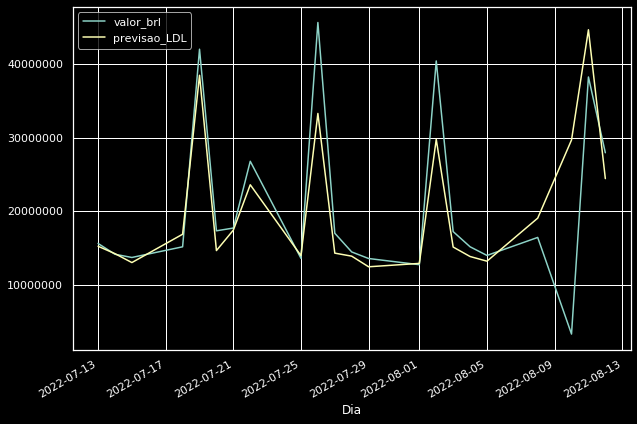

In [144]:
base_validacao[['valor_brl','previsao_LDL']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [145]:
def evaluate(model, xval, yval):
    predictions = model.predict(xval)
#     errors = abs(predictions - test_labels)
    wmape_w = wmape(predictions, base_validacao['valor_brl'])
    mape=mean_absolute_percentage_error(predictions, base_validacao['valor_brl'])
    MAE= mean_absolute_error(predictions, base_validacao['valor_brl'])
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    
    print('Model Performance')

    print(f'MAE: {MAE}')
    print(f'MAPE: {mape}')
    print(f'WMAPE: {wmape_w}')

In [146]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 10000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 3, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [20, 545, 1070, 1595, 2121, 2646, 3171, 3696, 4222, 4747, 5272, 5797, 6323, 6848, 7373, 7898, 8424, 8949, 9474, 10000], 'max_features': ['auto', 'sqrt', 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 3, 5], 'bootstrap': [True, False]}


In [147]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtr, ytr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for R

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6323; total time=  11.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6323; total time=  11.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6323; total time=  11.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  16.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  17.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7898; total time=  25.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7898; total time=  26.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7898; total time=  26.2s
[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  17.8s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  19.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  20.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  17.8s
[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=6848; total time=  25.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=7898; total time=  35.9s
[CV] END bootstrap=False, max_depth=No

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=6848; total time=  29.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=6848; total time=  28.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10000; total time=  28.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=7898; total time=  37.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2121; total time=   9.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10000; total time=  30.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=7898; total time=  41.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2121; total time=  10.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2121; total time=  11.6s
[CV] END bootstrap=False, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=5, n_estimators=4747; total time=  16.0s
[CV] END bootstrap=False, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=5, n_estimators=4747; total time=  15.7s
[CV] END bootstrap=False, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=5, n_estimators=4747; total time=  15.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=10000; total time=  29.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=5797; total time=  18.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6323; total time=  26.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=5797; total time=  16.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=5797; total time=  14.3s
[CV] END bootstrap=True, max_depth=40, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   3.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6323; total time=  26.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6323; total time=  28.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   2.8s
[CV] END bootstrap=True, max_depth=40, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   3.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1070; total time=   3.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1070; total time=   4.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  20.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for R

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  20.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=1070; total time=   3.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2646; total time=  10.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2646; total time=   9.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=   5.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=   6.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2646; total time=  11.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=   5.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=4747; total time=  19.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=2121; total time=   8.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=2121; total time=   7.5s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=2121; total time=   8.0s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=  12.7s
[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=   9.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=  11.9s
[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=   9.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=  13.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=   8.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1070; total time=   4.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1070; total time=   4.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1070; total time=   4.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=6848; total time=  14.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=6848; total time=  14.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=6848; total time=  14.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5272; total time=  20.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=6323; total time=  24.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5272; total time=  21.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=6323; total time=  26.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=6323; total time=  24.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=8949; total time=  38.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=8949; total time=  39.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=0.5, min_samples_leaf=5, min_samples_split=10, n_estimators=2646; total time=   9.7s
[CV] END bootstrap=True, max_depth=70, max_features=0.5, min_samples_leaf=5, min_samples_split=10, n_estimators=2646; total time=   9.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=8949; total time=  44.0s
[CV] END bootstrap=True, max_depth=70, max_features=0.5, min_samples_leaf=5, min_samples_split=10, n_estimators=2646; total time=  10.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=545; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=545; total time=   1.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=545; total time=   1.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=5272; total time=  23.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5797; total time=  25.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5797; total time=  23.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5797; total time=  25.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3171; total time=  16.7s
[CV] END bootstrap=True, max_depth=50, max_features=0.5, min_samples_leaf=3, min_samples_split=5, n_estimators=7898; total time=  25.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3171; total time=  15.6s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_f

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7373; total time=  23.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=3171; total time=  10.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  17.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  18.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6323; total time=  18.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7373; total time=  23.0s
[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=3171; total time=  10.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=3696; total time=  13.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=3696; total time=  13.8s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=3696; total time=  13.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9474; total time=  27.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9474; total time=  28.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=9474; total time=  27.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10000; total time=  45.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10000; total time=  48.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=10000; total time=  50.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=1595; total time=   8.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=8949; total time=  47.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=1595; total time=   8.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=8949; total time=  48.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=8949; total time=  27.2s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=1595; total time=   6.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=8949; total time=  27.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=8949; total time=  26.5s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4747; total time=  13.9s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=8949; total time=  43.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4747; total time=  14.9s
[CV] END bootstrap=True, max_depth=

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=1070; total time=   2.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  28.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  28.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  32.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=  12.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=  12.2s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=6323; total time=  22.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2121; total time=  11.0s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=6323; total time=  25.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=6323; total time=  24.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=6323; total time=  19.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  12.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=6323; total time=  19.6s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  15.5s
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  15.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=6323; total time=  17.8s
[CV] END bootstrap=False, max_depth=90, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=4222; total time=  15.3s
[CV] END bootstrap=False, max_depth=90, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=4222; total time=  16.4s
[CV] END bootstrap=False, max_depth=90, ma

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=7898; total time=  38.8s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=5797; total time=  15.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=6848; total time=  28.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=1595; total time=   7.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=5797; total time=  19.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=1595; total time=   7.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=7898; total time=  40.7s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=1595; total time=   7.2s
[CV] END bootstrap=False, max_depth=20, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=6848; total time=  26.8s
[CV] END bootstrap=False, max_depth=10, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=5797; total time=  20.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=3171; total time=  11.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=3171; total time=  10.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=3171; total time=  10.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=  12.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=  13.9s
[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  22.5s
[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  23.8s
[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  21.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=3171; total time=   9.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4747; total time=  10.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4747; total time=  11.3s
[CV] END bootstrap=False, max_dept

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=7898; total time=  25.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  12.8s
[CV] END bootstrap=False, max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  13.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=5, n_estimators=4747; total time=  14.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  25.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  24.7s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  25.9s
[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  19.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6848; total time=  34.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6848; total time=  34.9s
[CV] END bootstrap=False, max_depth=70, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=6323; total time=  19.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=2121; total time=   5.2s
[CV] END bootstrap=False, ma

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=7898; total time=  41.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  29.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  31.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10000; total time=  31.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5797; total time=  28.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=10000; total time=  37.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5797; total time=  30.2s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=10000; total time=  36.7s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=10000; total time=  34.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1595; total time=   7.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5797; total time=  23.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1595; total time=   7.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1595; total time=   6.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=7898; total time=  35.3s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=7898; total time=  36.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10000; total time=  30.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=7898; total time=  33.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=1070; total time=   3.4s
[CV] END bootstrap=False, max_depth

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=7373; total time=  25.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=7373; total time=  25.8s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=4222; total time=  13.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=4222; total time=  13.5s
[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=5797; total time=  19.9s
[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=5797; total time=  23.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=5797; total time=  23.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=545; total time=   3.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=545; total time=   3.3s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=545; total time=   2.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   2.9s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5797; total time=  28.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5797; total time=  30.2s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   3.4s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5797; total time=  29.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=8949; total time=  32.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=8949; total time=  32.0s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4222; total time=   9.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4222; total time=   9.8s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=8949; total time=  31.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=3696; total time=  13.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   1.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=3696; total time=  15.7s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=545; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=3696; total time=  15.5s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=4222; total time=  10.6s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1070; total time=   4.8s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1070; total time=   4.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1070; total time=   5.3s
[CV] END bootstrap=False, max_depth=80, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   4.6s
[CV] END bootstrap=False, max_depth=80, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=1070; total time=   3.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=4747; total time=  19.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=4747; total time=  20.1s
[CV] END bootstrap=False, max_

/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s


/home/stnog/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=0.5, min_samples_leaf=3, min_samples_split=10, n_estimators=545; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10000; total time=  33.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10000; total time=  31.6s
[CV] END bootstrap=True, max_depth=10, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=7898; total time=  23.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10000; total time=  27.3s
[CV] END bootstrap=True, max_depth=10, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=7898; total time=  24.6s
[CV] END bootstrap=True, max_depth=10, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=7898; total time=  17.3s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'min_samples_leaf': [1, 2, 4, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 545, 1070, 1595,
                                                         2121, 2646, 3171, 3696,
                                                         4222, 4747, 5272, 5797,
                                                         6323, 6848, 7373, 7898,
                                                         8424, 8949, 9474,
                                                         10000]},
                   random_state=1, verbose=2)

In [148]:
rf_random.best_params_

{'n_estimators': 4222,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 90,
 'bootstrap': False}

In [149]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, xval, base_validacao['valor_brl'])
print(random_accuracy)

Model Performance
MAE: 3205705.165027222
MAPE: 0.13546958872419132
WMAPE: 0.15881413796290683
None


In [150]:
##best_random.predict(xval)

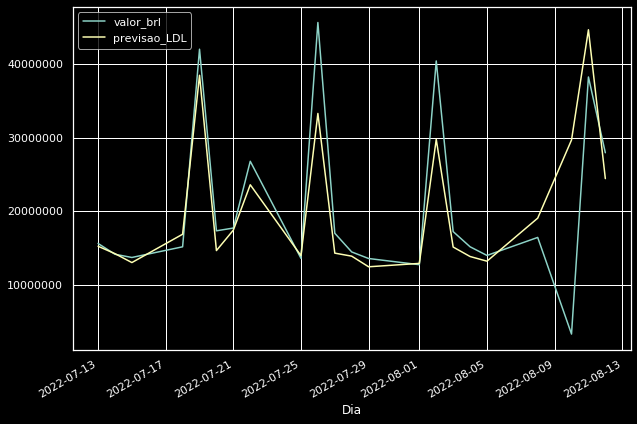

In [151]:
x = base_validacao[['valor_brl','previsao_LDL']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [152]:
mean_absolute_error(yval,p)

3804951.496647891

In [153]:
mean_absolute_percentage_error(yval,p)

0.462157336318478

In [154]:
wmape(yval, p)

0.1851317248837487

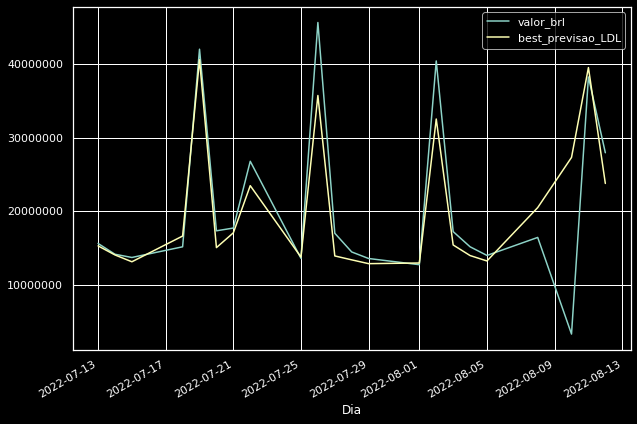

In [155]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']
p_best_rf= best_random.predict(xval)
base_validacao['best_previsao_LDL']= p_best_rf[:]
base_validacao[['valor_brl','best_previsao_LDL']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [156]:
## Boletos Celcoin; Boletos in; 

# XGBoost

In [157]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [158]:
reg = xgb.XGBRegressor(n_estimators=10000)

In [159]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

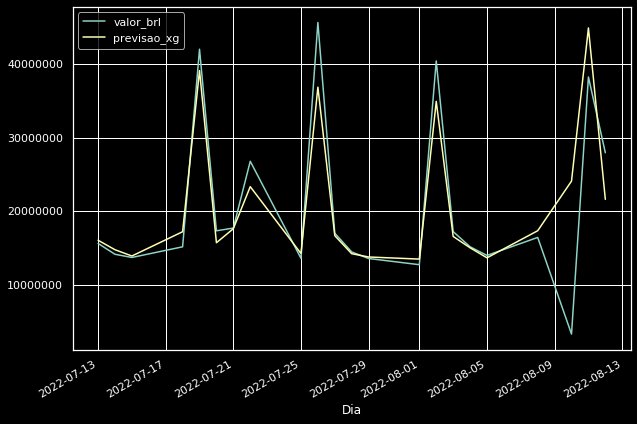

In [160]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [161]:
evaluate(reg,xval,yval)

Model Performance
MAE: 2895585.0527272727
MAPE: 0.11425354591643218
WMAPE: 0.13997836133149397


In [162]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [163]:
space={'max_depth':  hp.choice('max_depth', np.arange(3, 19, dtype=int)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 10000}

In [164]:
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( xtr, ytr), ( xval, yval)]
    
    model.fit(xtr, ytr,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(xval)
    wmape_w = wmape(pred, base_validacao['valor_brl'])
    mape=mean_absolute_percentage_error(pred, base_validacao['valor_brl'])
    MAE= mean_absolute_error(pred, base_validacao['valor_brl'])
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    #change the metric if you like
    return {'loss':wmape_w, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

100%|██████████| 100/100 [00:54<00:00,  1.82trial/s, best loss: 0.11884112362866688]
{'colsample_bytree': 0.8823243267254771, 'gamma': 4.180274489832648, 'max_depth': 5, 'min_child_weight': 3.0, 'reg_alpha': 128.0, 'reg_lambda': 0.3415254746671403}


In [169]:
reg = xgb.XGBRegressor(n_estimators=10000, colsample_bytree = 0.8823243267254771, gamma = 4.180274489832648, max_depth = 5, min_child_weight = 3.0, reg_alpha = 128.0, reg_lambda = 0.3415254746671403)

In [170]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8823243267254771, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=4.180274489832648, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3.0,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=128.0, reg_lambda=0.3415254746671403, ...)

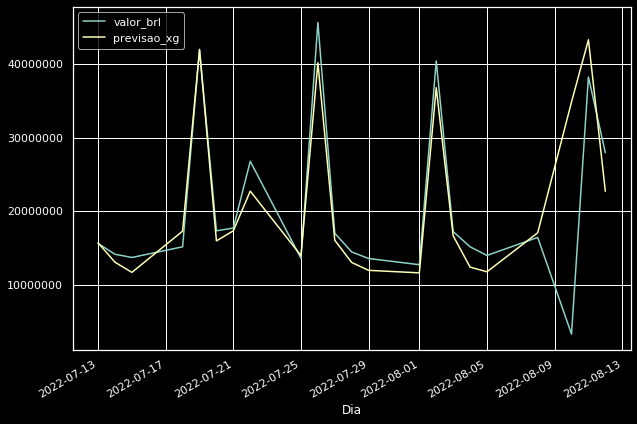

In [171]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [173]:
evaluate(reg, xval, yval)

Model Performance
MAE: 3356940.647272728
MAPE: 0.13958448661756062
WMAPE: 0.1612535562262799


In [176]:
base_validacao = base_validacao[base_validacao['valor_brl']!=base_validacao['valor_brl'].min()]

In [178]:
reg = xgb.XGBRegressor(n_estimators=10000)

In [179]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

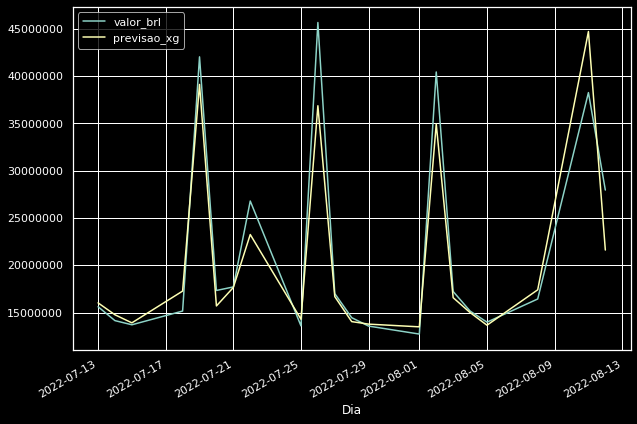

In [181]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(10,7))

In [183]:
evaluate(reg,xval,yval)

Model Performance
MAE: 2053017.6457142858
MAPE: 0.07964456534238921
WMAPE: 0.10011451071438285
